In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
import japanize_matplotlib
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#試合データの読み込み
atp2018=pd.read_csv("../tennis_atp/atp_matches_2018.csv")

In [3]:
#疲労度の取得
#alpha:疲労残存率
#適用可能なのはR128の大会のみ

def get_fatigue(alpha):
    out=atp2018[(atp2018["best_of"]==5)]
    out["winner_totalminutes"]=-99
    out["loser_totalminutes"]=-99
    for index, row in out.iterrows():
        if row["round"]=="R128":
            out.loc[index,"winner_totalminutes"]=0
            out.loc[index,"loser_totalminutes"]=0
        elif row["round"]=="R64":
            out.loc[index,"winner_totalminutes"]=out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R128")]["minutes"].values
            out.loc[index,"loser_totalminutes"]=out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R128")]["minutes"].values
        elif row["round"]=="R32":
            out.loc[index,"winner_totalminutes"]=out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R64")]["minutes"].values \
                                                        + out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R64")]["winner_totalminutes"].values  * alpha
            out.loc[index,"loser_totalminutes"]=out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R64")]["minutes"].values \
                                                        +out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"]) 
                                                     & (out["round"]=="R64")]["winner_totalminutes"].values * alpha
        elif row["round"]=="R16":
            out.loc[index,"winner_totalminutes"]=out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R32")]["minutes"].values \
                                                        + out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R32")]["winner_totalminutes"].values * alpha
            out.loc[index,"loser_totalminutes"]=out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R32")]["minutes"].values \
                                                        +out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R32")]["winner_totalminutes"].values * alpha
        elif row["round"]=="QF":
            out.loc[index,"winner_totalminutes"]=out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R16")]["minutes"].values \
                                                        + out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R16")]["winner_totalminutes"].values * alpha
            out.loc[index,"loser_totalminutes"]=out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R16")]["minutes"].values \
                                                        +out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="R16")]["winner_totalminutes"].values * alpha
        elif row["round"]=="SF":
            out.loc[index,"winner_totalminutes"]=out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="QF")]["minutes"].values \
                                                        + out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="QF")]["winner_totalminutes"].values * alpha
            out.loc[index,"loser_totalminutes"]=out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="QF")]["minutes"].values \
                                                        +out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="QF")]["winner_totalminutes"].values * alpha
        elif row["round"]=="F":
            out.loc[index,"winner_totalminutes"]=out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="SF")]["minutes"].values \
                                                        + out[(out["winner_name"]==row["winner_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="SF")]["winner_totalminutes"].values * alpha
            out.loc[index,"loser_totalminutes"]=out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="SF")]["minutes"].values \
                                                        +out[(out["winner_name"]==row["loser_name"]) & (out["tourney_id"]==row["tourney_id"])
                                                     & (out["round"]=="SF")]["winner_totalminutes"].values * alpha
    
    #レーティングの付与
    out["winner_rating"]=out["winner_name"].map(d)
    out["loser_rating"]=out["loser_name"].map(d)

    out["rate_diff"]=out["winner_rating"]-out["loser_rating"]
    out["fatigue_diff"]=out["winner_totalminutes"]-out["loser_totalminutes"]

    return out

In [4]:
#イロレーティングの読み込み
elo2018=pd.read_csv("../elo/Rankings_2018_ye.csv")

In [5]:
elo2018.head()

,rank,name,country_name,country_id,points,bestRank,bestRankDate,rankDiff,pointsDiff,bestPoints
0,1,Rafael Nadal,Spain,ESP,2408,1,2008-06-16,0,0,2552
1,2,Novak Djokovic,Serbia,SRB,2401,1,2011-03-21,0,0,2629
2,3,Roger Federer,Switzerland,SUI,2356,1,2003-08-11,0,0,2550
3,4,Juan Martin Del Potro,Argentina,ARG,2264,3,2010-06-07,0,0,2329
4,5,Andy Murray,United Kingdom,GBR,2255,2,2009-04-19,0,0,2500


In [6]:
#表記揺れへの対応
elo2018.loc[elo2018['name'] == "Frances Tiafoe", 'name'] = "Francis Tiafoe"
elo2018.loc[elo2018['name'] == "Stan Wawrinka", 'name'] = "Stanislas Wawrinka"

In [7]:
#名前とレーティングの辞書化
d={}
for i,j in zip(elo2018["name"].values,elo2018["points"].values):
    d[i]=j

In [8]:
#疲労度の取得
data=get_fatigue(0.8)

#4大大会でないデータを除外
data=data[data["round"]!="RR"]

#レーティングのデータが入っていない人がいる行を除外
data=data.dropna(subset=["winner_rating","loser_rating"])

#回帰に入れるためのデータ整形
X1=data[["rate_diff","fatigue_diff"]]
X1["win"]=1

#勝敗を反転させたデータの追加
X2=data[["rate_diff","fatigue_diff"]]
X2["rate_diff"]=-X2["rate_diff"]
X2["fatigue_diff"]=-X2["fatigue_diff"]
X2["win"]=0

X12=pd.concat([X1,X2])
y=X12["win"]
X=X12.drop(["win"],axis=1)

In [9]:
#ロジスティック回帰の実施
import statsmodels.api as sm
logit_mod = sm.Logit(y, X)
logit_res = logit_mod.fit(disp=0)

In [10]:
#オッズ比
params = logit_res.params
conf = logit_res.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
pd.DataFrame(np.exp(conf))

,2.5%,97.5%,OR
rate_diff,1.006018,1.007961,1.006989
fatigue_diff,0.991332,0.997861,0.994591


In [11]:
#ロジスティック回帰の正答率
1-(((logit_res.predict(X)>0.5).astype(int)-y)**2).sum()/X.shape[0]

0.7634854771784232

In [12]:
#交差検証で確認してみる
import lightgbm as lgb
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

#交差検証（４分割）
sss = StratifiedKFold(n_splits=4, random_state=94)
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
        #print('[Fold %d/%d]' % (i + 1, kfold))

        logit_mod = sm.Logit(np.array(y)[train_index], np.array(X)[train_index])
        logit_res = logit_mod.fit(disp=0)
        #print(logit_res.summary())
        
        params = np.exp(logit_res.params)
        print(params)
        

[1.0076733  0.99565663]
[1.00716624 0.996895  ]
[1.00705972 0.99020322]
[1.00629753 0.99528754]


Training until validation scores don't improve for 50 rounds.
[10]	training's binary_error: 0.224377	valid_1's binary_error: 0.252066
[20]	training's binary_error: 0.224377	valid_1's binary_error: 0.252066
[30]	training's binary_error: 0.216066	valid_1's binary_error: 0.252066
[40]	training's binary_error: 0.210526	valid_1's binary_error: 0.260331
[50]	training's binary_error: 0.207756	valid_1's binary_error: 0.260331
Early stopping, best iteration is:
[1]	training's binary_error: 0.227147	valid_1's binary_error: 0.247934
Training until validation scores don't improve for 50 rounds.
[10]	training's binary_error: 0.227147	valid_1's binary_error: 0.243802
[20]	training's binary_error: 0.224377	valid_1's binary_error: 0.252066
[30]	training's binary_error: 0.221607	valid_1's binary_error: 0.247934
[40]	training's binary_error: 0.216066	valid_1's binary_error: 0.247934
[50]	training's binary_error: 0.217452	valid_1's binary_error: 0.243802
[60]	training's binary_error: 0.217452	valid_1's b

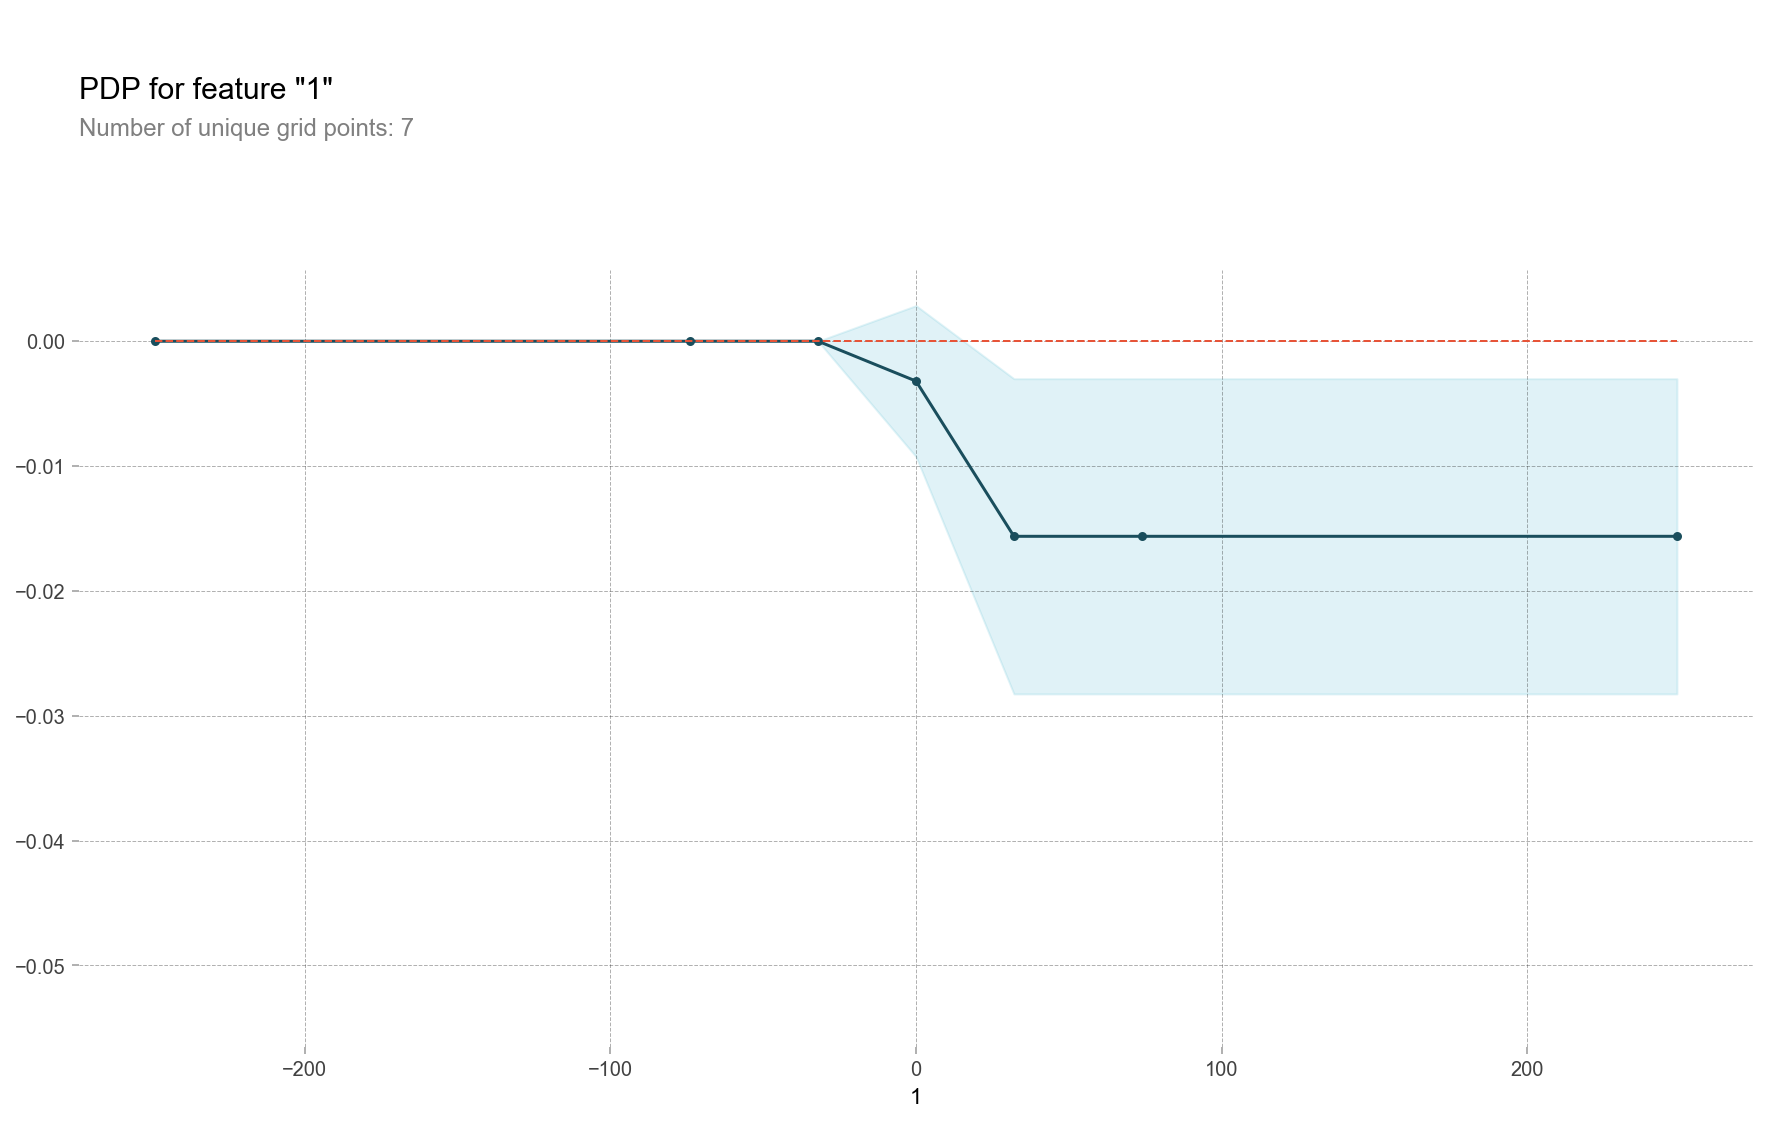

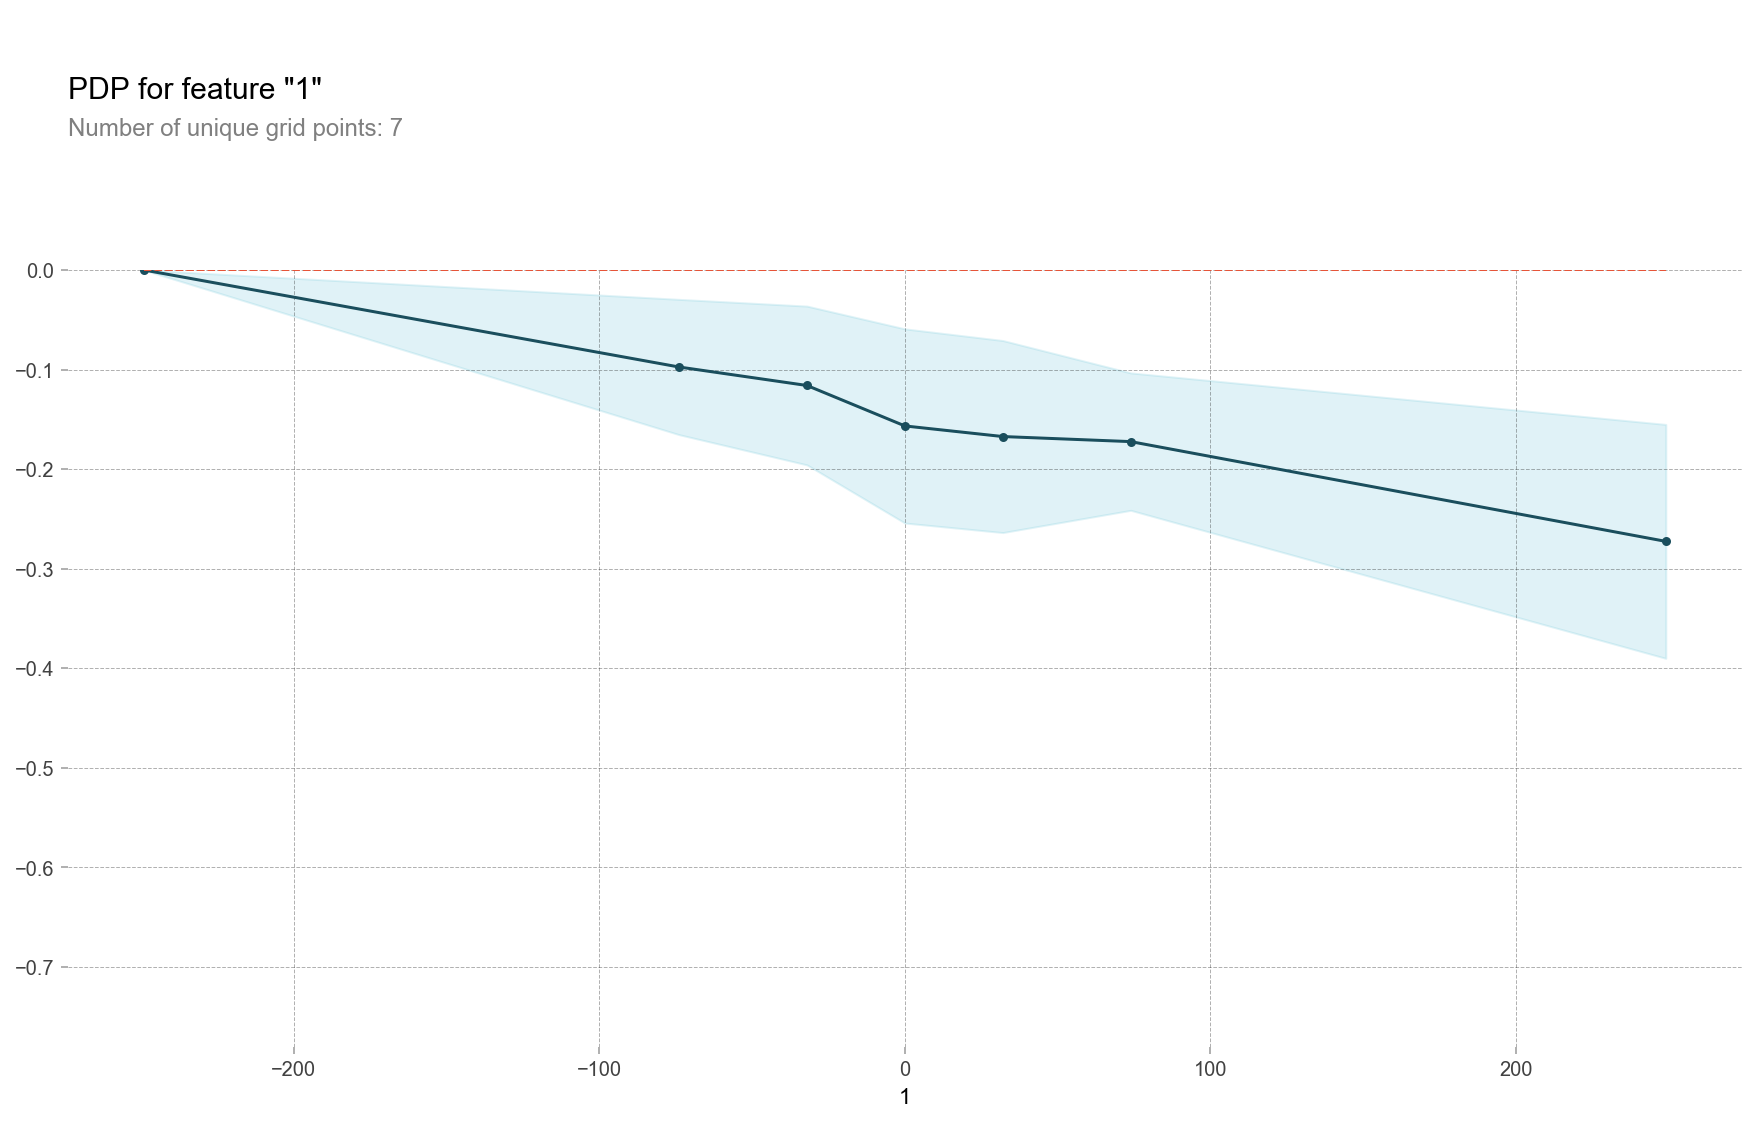

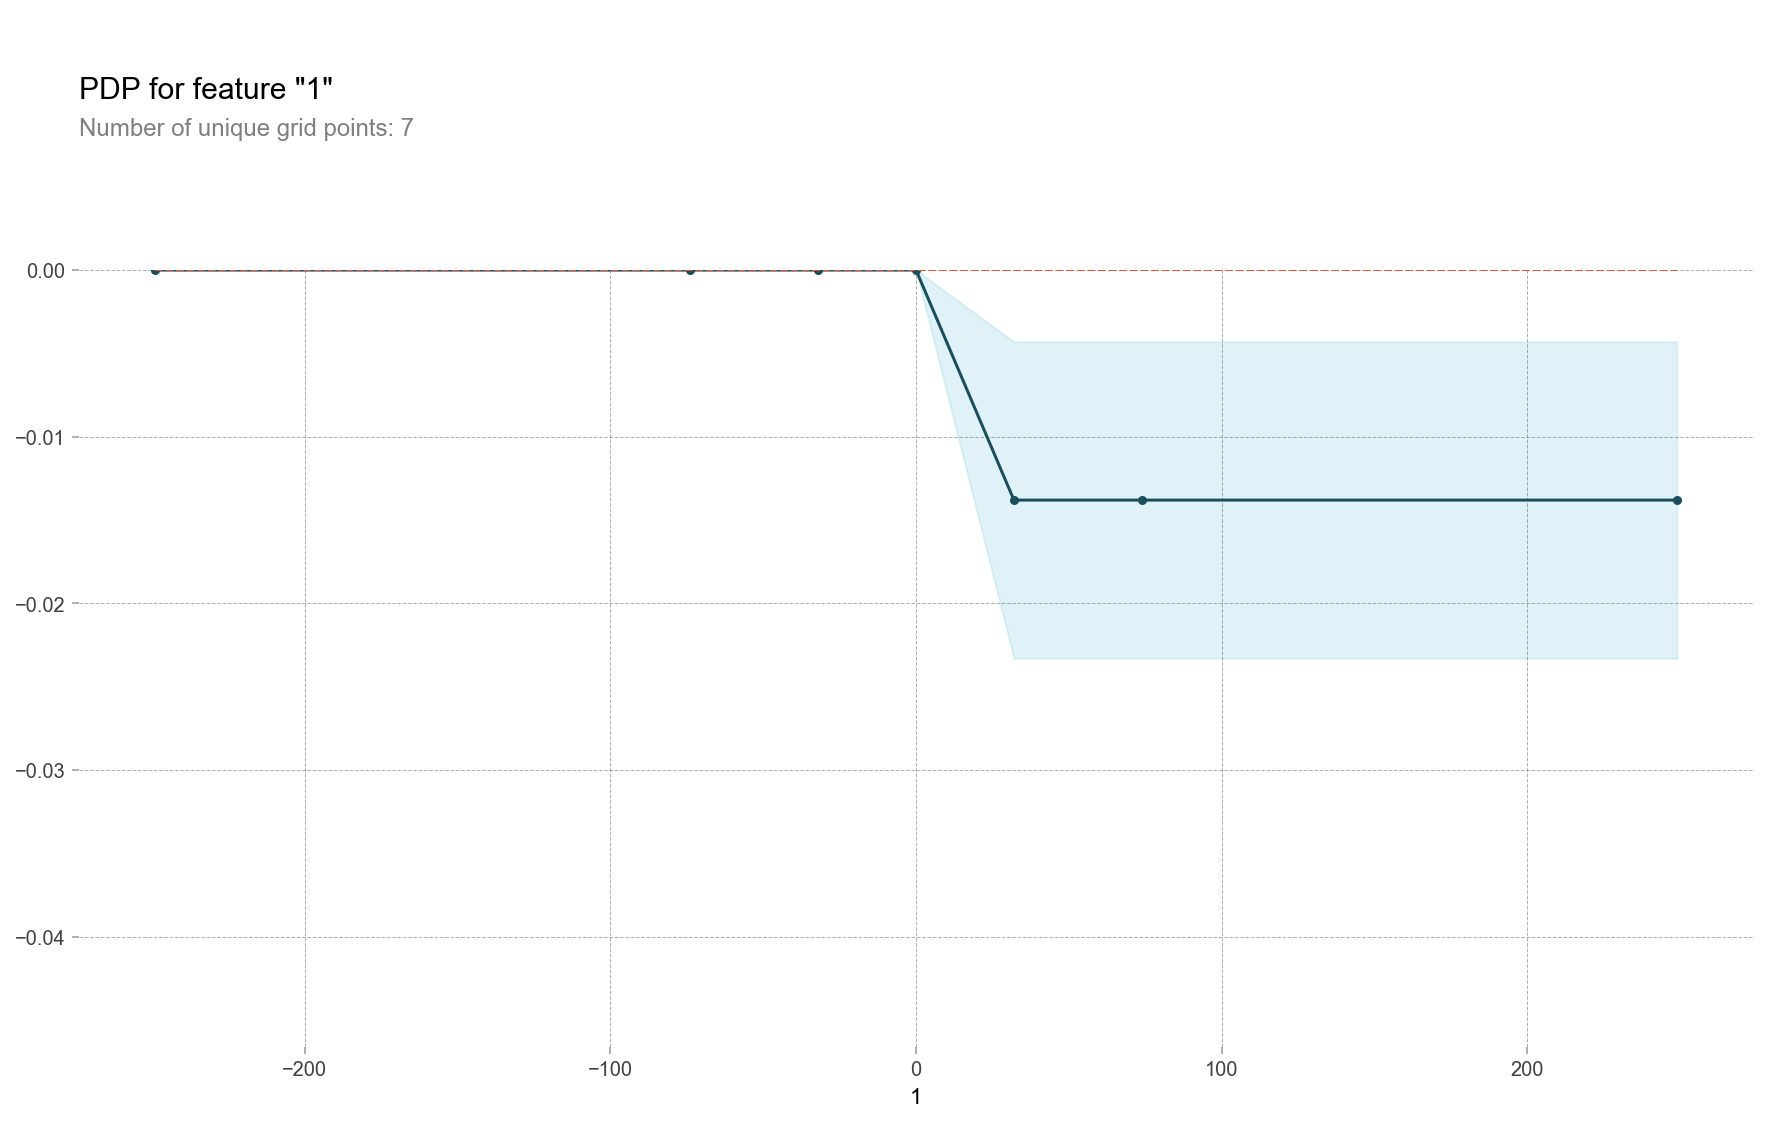

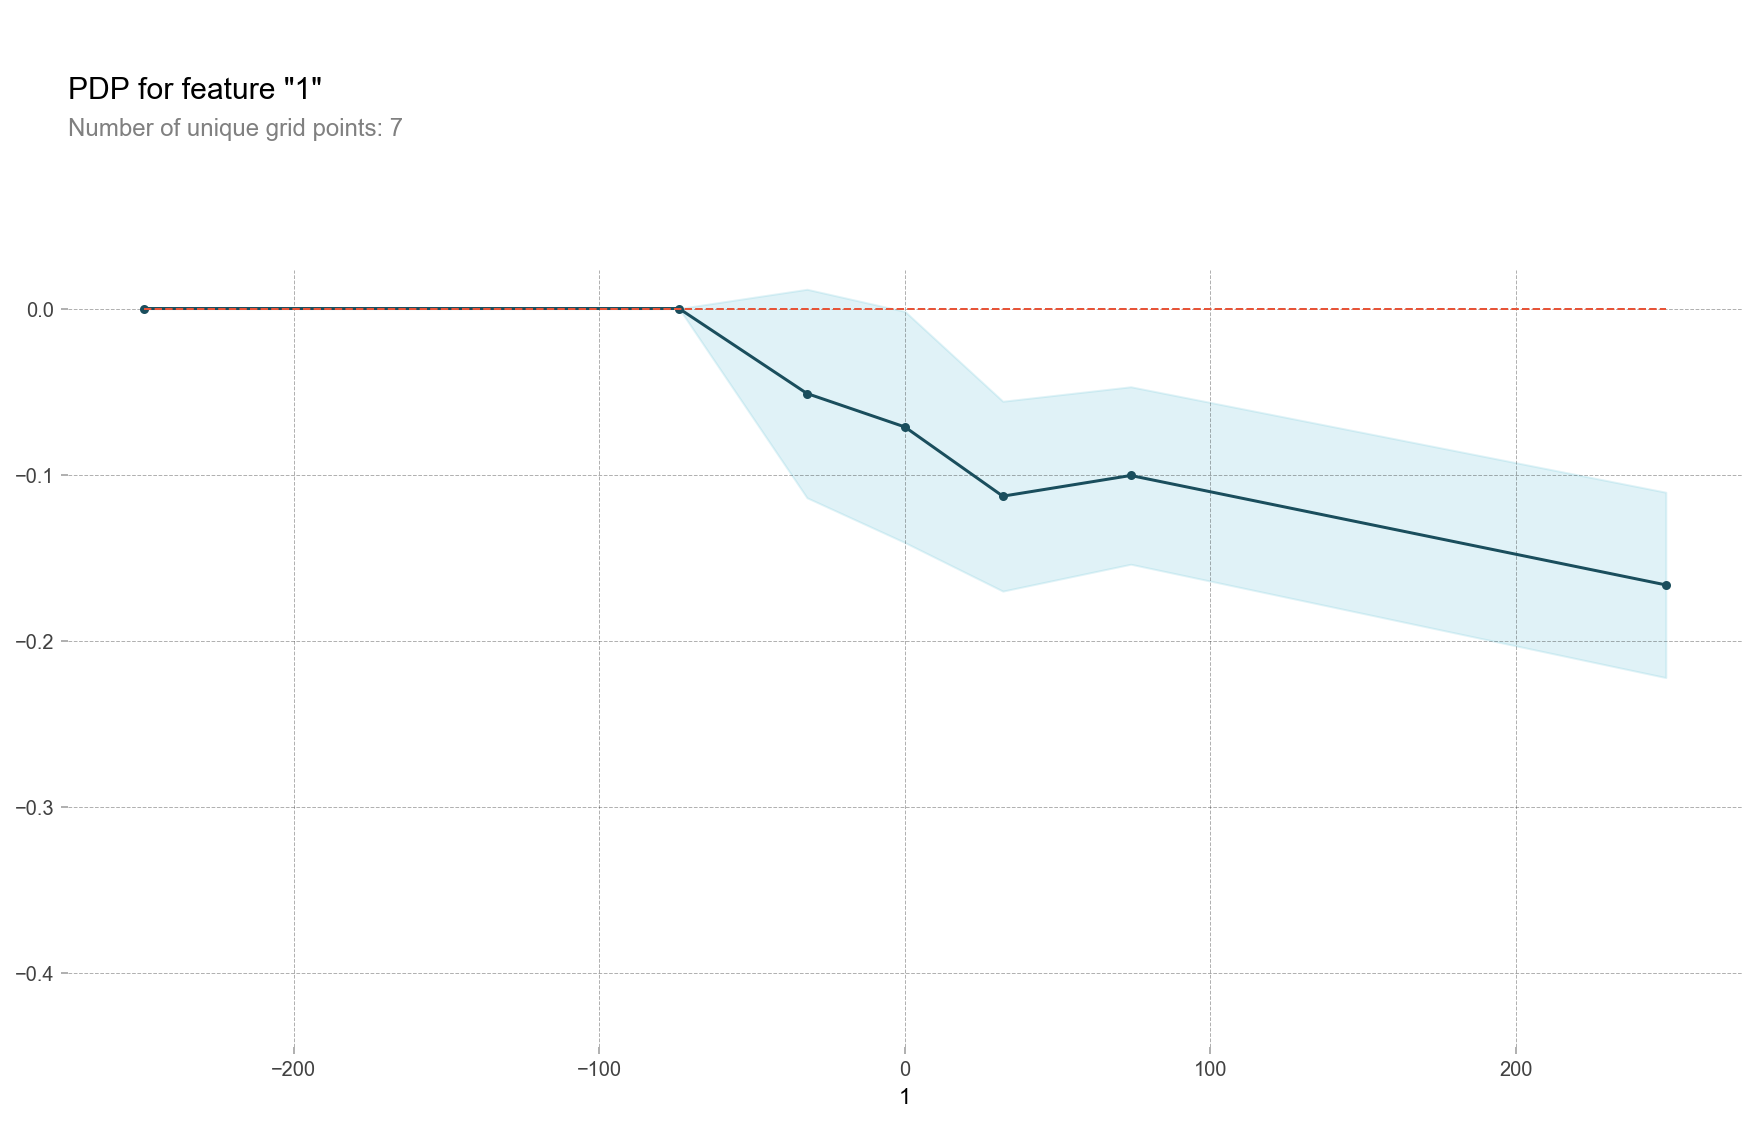

In [13]:
#LGBM+PDPでやってみる
import lightgbm as lgb
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from pdpbox import pdp
import copy

params={
    'random_state' : 1,
    "objective": "binary",
    "metric": "binary_error",
    "max_depth":3, #データ量すくないので控えめ
    }

total_ice_lines=pd.DataFrame()
sss = StratifiedKFold(n_splits=4, random_state=77,shuffle=True)
importance=0
score=0
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    #print('[Fold %d/%d]' % (i + 1, kfold))
    
    X_train, X_valid = np.array(X)[train_index,:], np.array(X)[test_index,:]
    y_train, y_valid = np.array(y)[train_index], np.array(y)[test_index]
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid)
    
    bst = lgb.train(params, dtrain, num_boost_round=1000,valid_sets=[dtrain, dvalid],early_stopping_rounds=50,verbose_eval=10)
    #bst = lgb.train(params, dtrain, num_boost_round=1000,valid_sets=[dvalid],early_stopping_rounds=50,verbose_eval=10)
    
    importance+= pd.DataFrame(bst.feature_importance(), index=X.columns, columns=['importance'])
    score+=bst.best_score["valid_1"]['binary_error']
    
    pdp_dist = pdp.pdp_isolate(model=bst, dataset=pd.DataFrame(X_valid), model_features=[0,1], feature=1,#grid_type="equal",
                              cust_grid_points=[-249,-73.91,-32.04,0,32.04,73.91,249]) #1回autoで回した時の値を使用
    total_ice_lines=pd.concat([total_ice_lines,pdp_dist.ice_lines])
    pdp.pdp_plot(pdp_dist, 1)
    #break

In [14]:
#精度
1-score/4

0.7603822314049586

In [15]:
#out of foldで算出した値の表示用
pdp_dist.ice_lines=total_ice_lines

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c26c8efd0>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c26cb92e8>})

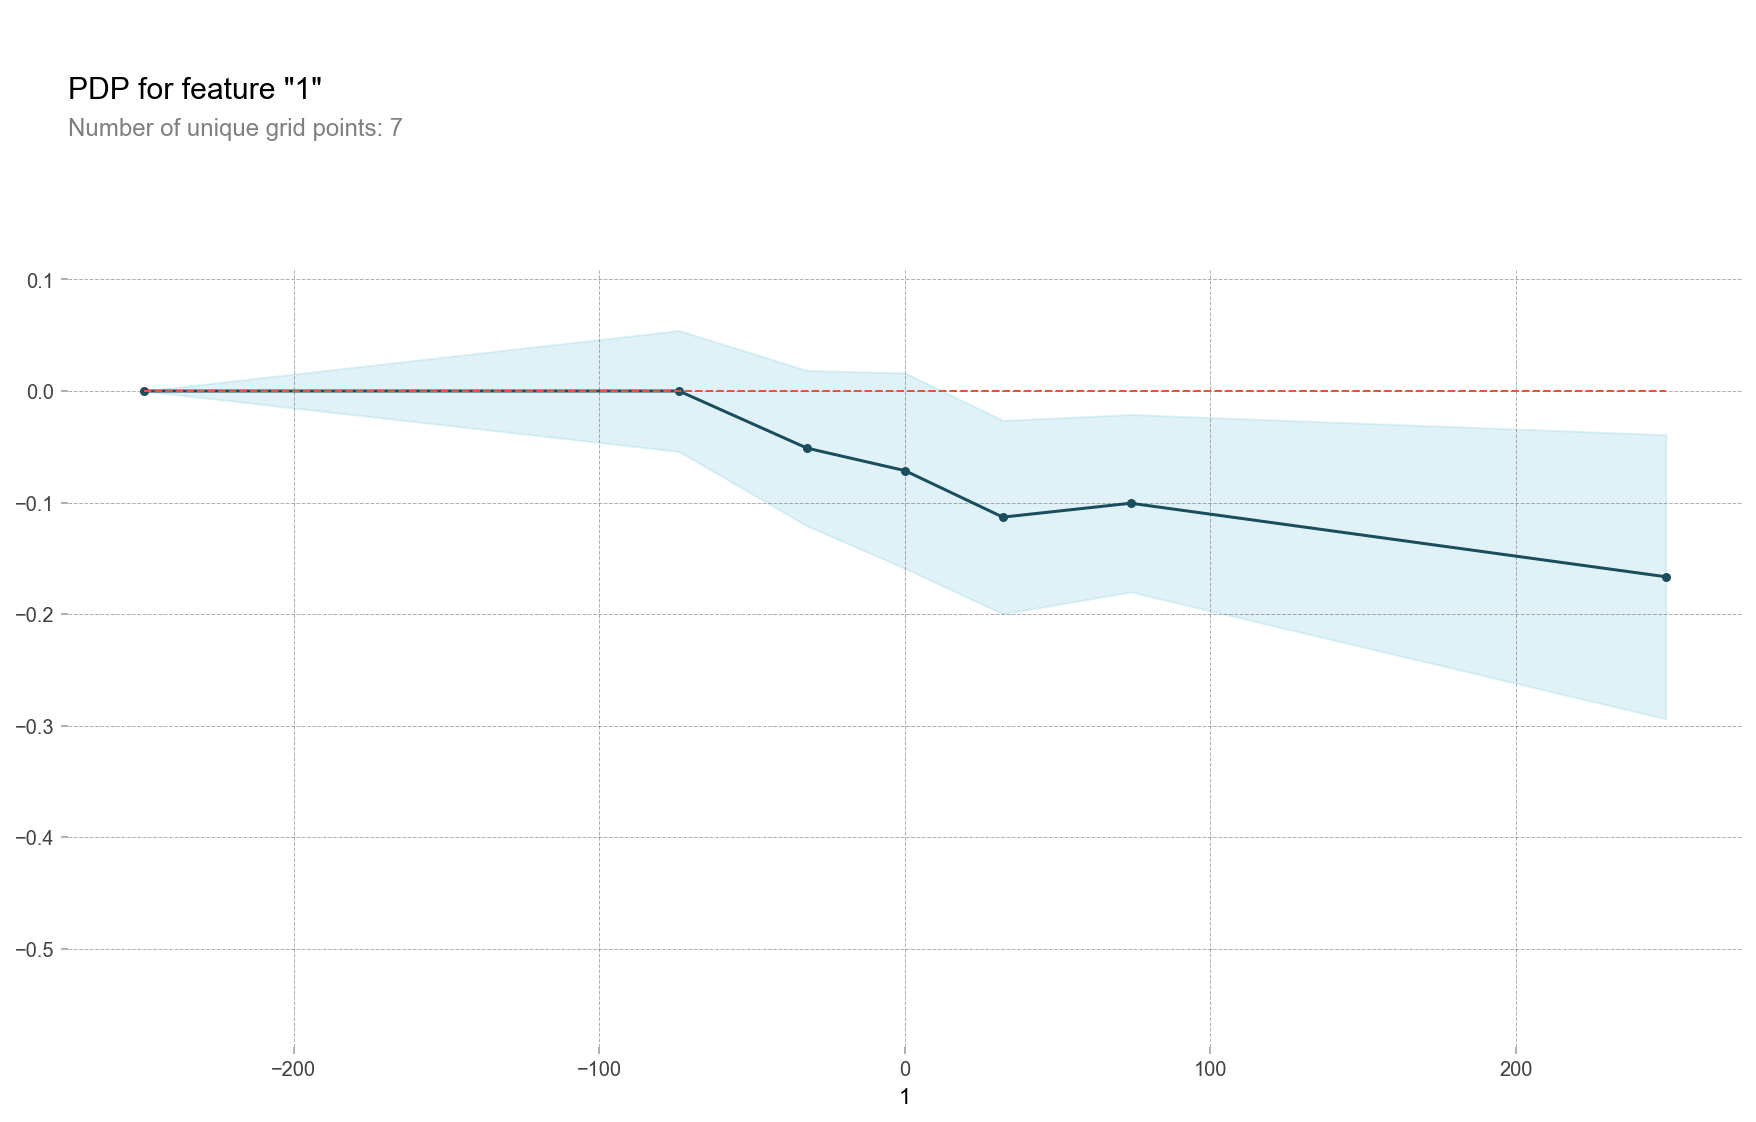

In [16]:
#3回全ての値を使った場合
pdp.pdp_plot(pdp_dist, 1)

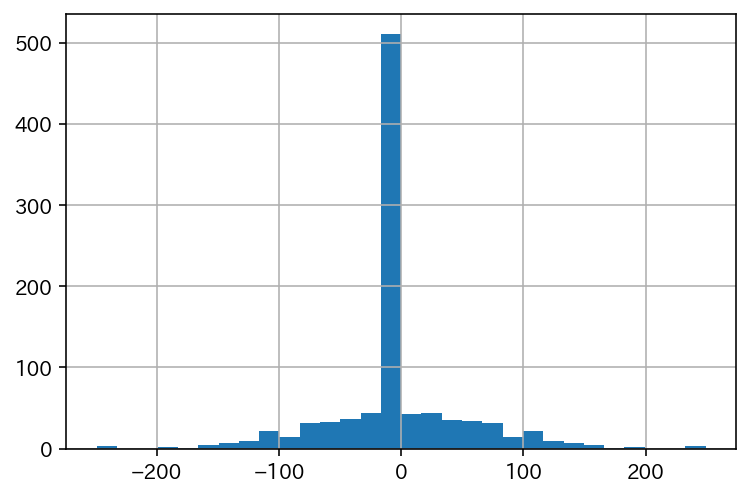

In [17]:
X["fatigue_diff"].hist(bins=30)

In [18]:
X[X["fatigue_diff"]>100].shape[0]

48

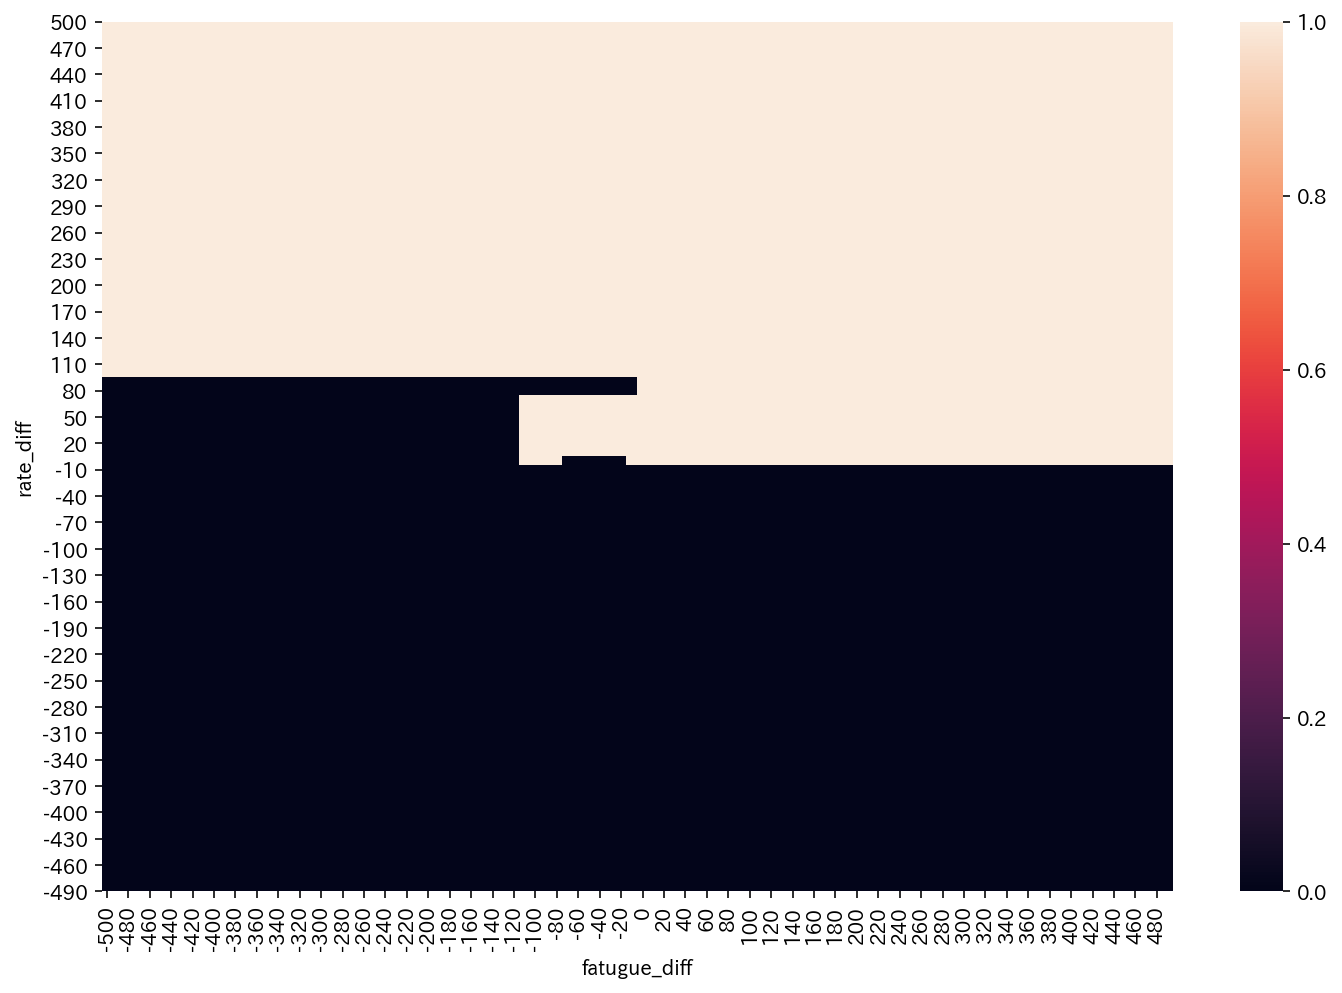

In [19]:
#lightgbmの予測値の２次元プロット
arr=np.zeros((100,100))
xlabel=[]
ylabel=[]
for i in range(100):
    for j in range(100):
        arr[i,j]=bst.predict(np.array([[-500+i*10,-500+j*10]]))
        
x_ind=[-500+i*10 for i in range(100)]
y_ind=[500-i*10 for i in range(100)]

tmp=(pd.DataFrame(arr)>0.5).astype(int).iloc[::-1,::-1]
tmp.columns=x_ind
tmp.index=y_ind

plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(tmp))
plt.xlabel("fatugue_diff")
plt.ylabel("rate_diff")
plt.show()